In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
from PIL import Image
import torch
from torch import nn
from torchvision import datasets
import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import save_image
from torch.utils.data import DataLoader

In [2]:
transform = T.Compose([T.Resize((128, 128)),
                       T.ToTensor()])
train_dataset = datasets.ImageFolder(
    root := '/kaggle/input/isl-dataset/final_data/train',
    transform = transform
)
val_dataset = datasets.ImageFolder(
    root := '/kaggle/input/isl-dataset/final_data/val',
    transform = transform
)

In [25]:
batch_size = 64
train_dl = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

In [4]:
device = "cuda"

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Conv2d(3,16,3,1,1), #(in_channels, out_channels, kernel_size, stride, padding)
            nn.ReLU(),
            nn.MaxPool2d(2,2),  #128 -> 64
            nn.Conv2d(16,32,3,1,1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),  #64 -> 32
            nn.Conv2d(32,64,3,1,1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),  #32 -> 16
            
            nn.Flatten(),
            nn.Linear(16*16*64, 1024),
            nn.ReLU(),
            nn.Linear(1024, 35),
            nn.Softmax()
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits

In [26]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_stack): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=16384, out_features=1024, bias=True)
    (11): ReLU()
    (12): Linear(in_features=1024, out_features=35, bias=True)
    (13): Softmax(dim=None)
  )
)


In [27]:
def train(model, dataloader, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    for batch, (x,y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        
        temp.append(loss.detach().cpu().numpy())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch%100 == 0:
            loss, current = loss.item(), batch*len(x)
            print(f"Loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    Train_loss.append(np.mean(temp))

In [23]:
prevAcc = 0.0
def validation(model, dataloader, loss_fn):
    size = len(dataloader.dataset)
    batch_num = len(dataloader)
    model.eval()
    
    test_loss, correct = 0, 0
    for batch, (x,y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
    test_loss /= batch_num
    Val_loss.append(test_loss)
    correct /= size
    print(f"Test Error:\n Accuracy:{correct*100:>0.1f}% Avg Loss:{test_loss:>8f}\n")
    
    global prevAcc
    if prevAcc < correct:
        torch.save(model.state_dict(), "model.pth")
        print("Saved Successfully!!!")
        prevAcc = correct

In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Epoch 1---------------------

Loss: 3.555403 [    0/29919]
Loss: 3.163660 [ 6400/29919]
Loss: 3.192247 [12800/29919]
Loss: 3.010024 [19200/29919]
Loss: 2.868664 [25600/29919]
Evaluating the model now
Test Error:
 Accuracy:84.6% Avg Loss:2.756602

Saved Successfully!!!


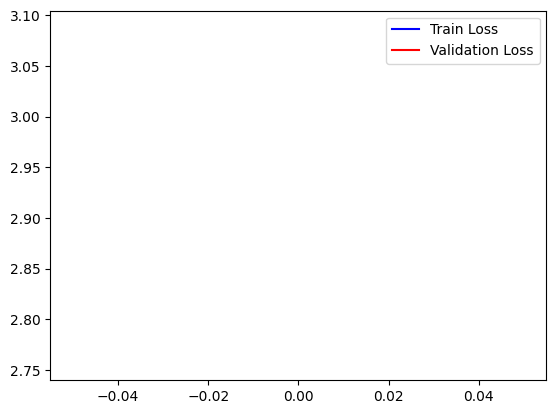

Epoch 2---------------------

Loss: 2.743600 [    0/29919]
Loss: 2.650024 [ 6400/29919]
Loss: 2.680936 [12800/29919]
Loss: 2.618635 [19200/29919]
Loss: 2.634261 [25600/29919]
Evaluating the model now
Test Error:
 Accuracy:96.0% Avg Loss:2.642919

Saved Successfully!!!


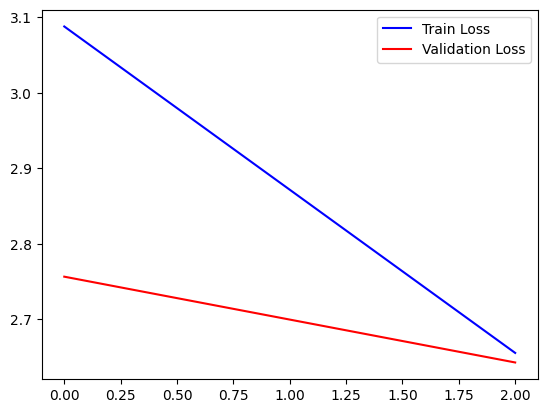

Epoch 3---------------------

Loss: 2.664972 [    0/29919]
Loss: 2.664984 [ 6400/29919]
Loss: 2.649334 [12800/29919]
Loss: 2.649604 [19200/29919]
Loss: 2.649596 [25600/29919]
Evaluating the model now
Test Error:
 Accuracy:96.0% Avg Loss:2.642889



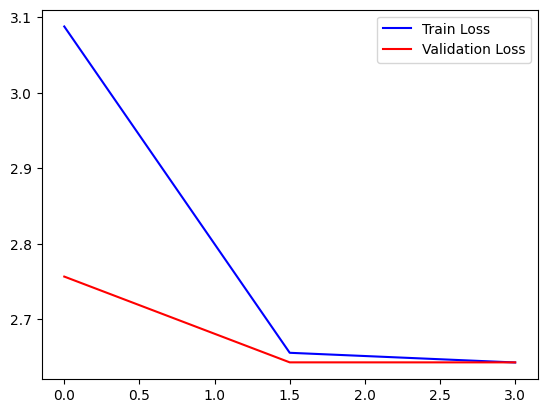

Epoch 4---------------------

Loss: 2.603275 [    0/29919]
Loss: 2.618900 [ 6400/29919]
Loss: 2.618899 [12800/29919]
Loss: 2.618900 [19200/29919]
Loss: 2.603275 [25600/29919]
Evaluating the model now
Test Error:
 Accuracy:98.8% Avg Loss:2.615401

Saved Successfully!!!


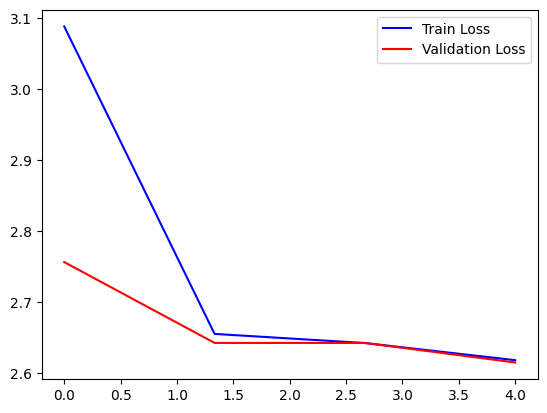

Epoch 5---------------------

Loss: 2.618900 [    0/29919]
Loss: 2.603274 [ 6400/29919]
Loss: 2.634524 [12800/29919]
Loss: 2.603274 [19200/29919]
Loss: 2.603275 [25600/29919]
Evaluating the model now
Test Error:
 Accuracy:98.8% Avg Loss:2.615401



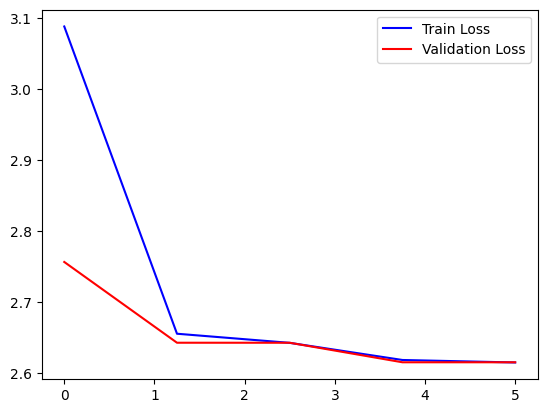

Epoch 6---------------------

Loss: 2.603274 [    0/29919]
Loss: 2.618899 [ 6400/29919]
Loss: 2.618899 [12800/29919]
Loss: 2.618899 [19200/29919]
Loss: 2.618899 [25600/29919]
Evaluating the model now
Test Error:
 Accuracy:98.8% Avg Loss:2.615401



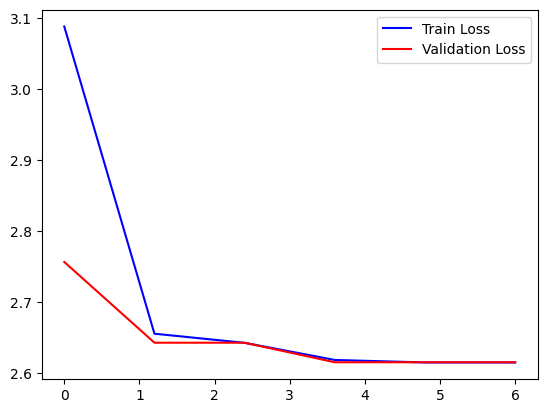

Epoch 7---------------------

Loss: 2.603274 [    0/29919]
Loss: 2.634524 [ 6400/29919]
Loss: 2.618899 [12800/29919]
Loss: 2.618899 [19200/29919]
Loss: 2.603274 [25600/29919]
Evaluating the model now
Test Error:
 Accuracy:98.8% Avg Loss:2.615401



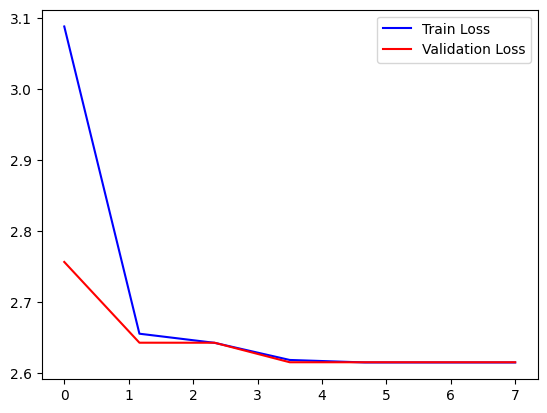

Epoch 8---------------------

Loss: 2.603274 [    0/29919]
Loss: 2.603275 [ 6400/29919]
Loss: 2.634524 [12800/29919]
Loss: 2.603274 [19200/29919]
Loss: 2.603274 [25600/29919]
Evaluating the model now
Test Error:
 Accuracy:98.8% Avg Loss:2.615401



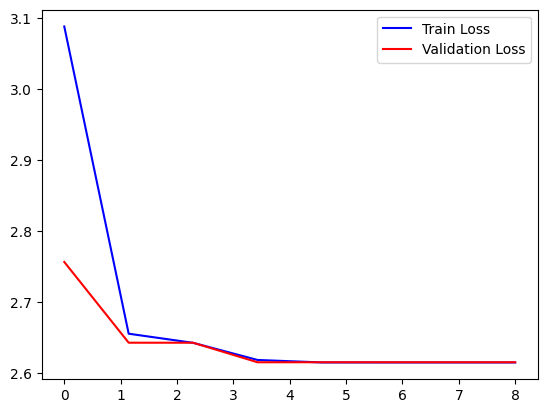

Epoch 9---------------------

Loss: 2.603274 [    0/29919]
Loss: 2.603274 [ 6400/29919]
Loss: 2.634524 [12800/29919]
Loss: 2.603274 [19200/29919]
Loss: 2.665774 [25600/29919]
Evaluating the model now
Test Error:
 Accuracy:98.8% Avg Loss:2.615401



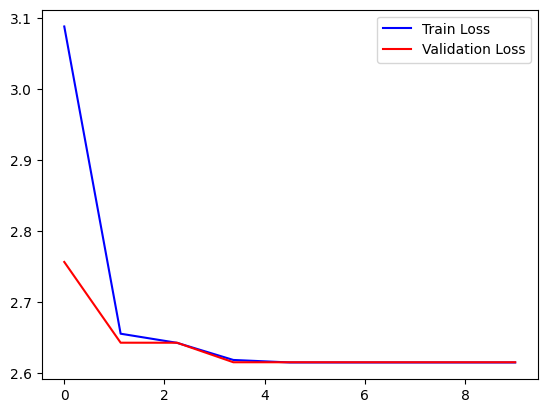

Epoch 10---------------------

Loss: 2.634524 [    0/29919]
Loss: 2.618899 [ 6400/29919]
Loss: 2.618899 [12800/29919]
Loss: 2.603274 [19200/29919]
Loss: 2.634524 [25600/29919]
Evaluating the model now
Test Error:
 Accuracy:98.8% Avg Loss:2.615401



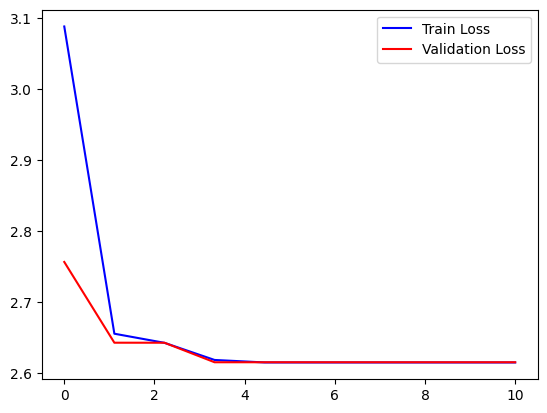

Done!! Best Accuracy: 98.783199


In [29]:
Train_loss = []
Val_loss = []
epochs = 10

for t in range(0, epochs):
    print(f"Epoch {t+1}---------------------\n")
    temp = []
    train(model, train_dl, loss_fn, optimizer)
    print("Evaluating the model now")
    validation(model, val_dl, loss_fn)
    
    x = torch.linspace(0, len(Train_loss), len(Train_loss))
    plt.plot(x, Train_loss, color = 'blue', label = 'Train Loss')
    plt.plot(x, Val_loss, color = 'red', label = 'Validation Loss')
    plt.legend(loc = "upper right")
    plt.show()
print(f"Done!! Best Accuracy: {prevAcc*100:>5f}")

In [30]:
test_dataset = datasets.ImageFolder(
    root := '/kaggle/input/isl-dataset/final_data/test',
    transform = transform
)
test_dl = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [32]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for image, label in test_dl:
        image = image.to(device)
        output = model(image)
        _, pred = torch.max(output, 1)
        y_true.extend(label.numpy())
        y_pred.extend(pred.detach().cpu().numpy())
y_true = np.array(y_true)
y_pred = np.array(y_pred)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [34]:
target_names = ['1','2','3','4','5','6','7','8','9',
                'A','B','C','D','E','F','G','H','I',
                'J','K','L','M','N','O','P','Q','R',
                'S','T','U','V','W','X','Y','Z']
print(classification_report(y_true, y_pred, target_names = target_names))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       120
           2       1.00      1.00      1.00       120
           3       1.00      1.00      1.00       120
           4       1.00      1.00      1.00       120
           5       1.00      1.00      1.00       120
           6       1.00      1.00      1.00       120
           7       1.00      1.00      1.00       120
           8       1.00      1.00      1.00       120
           9       1.00      1.00      1.00       120
           A       1.00      1.00      1.00       120
           B       1.00      1.00      1.00       120
           C       1.00      0.79      0.88       146
           D       1.00      1.00      1.00       120
           E       1.00      1.00      1.00       120
           F       1.00      1.00      1.00       120
           G       1.00      1.00      1.00       120
           H       1.00      1.00      1.00       120
           I       1.00    

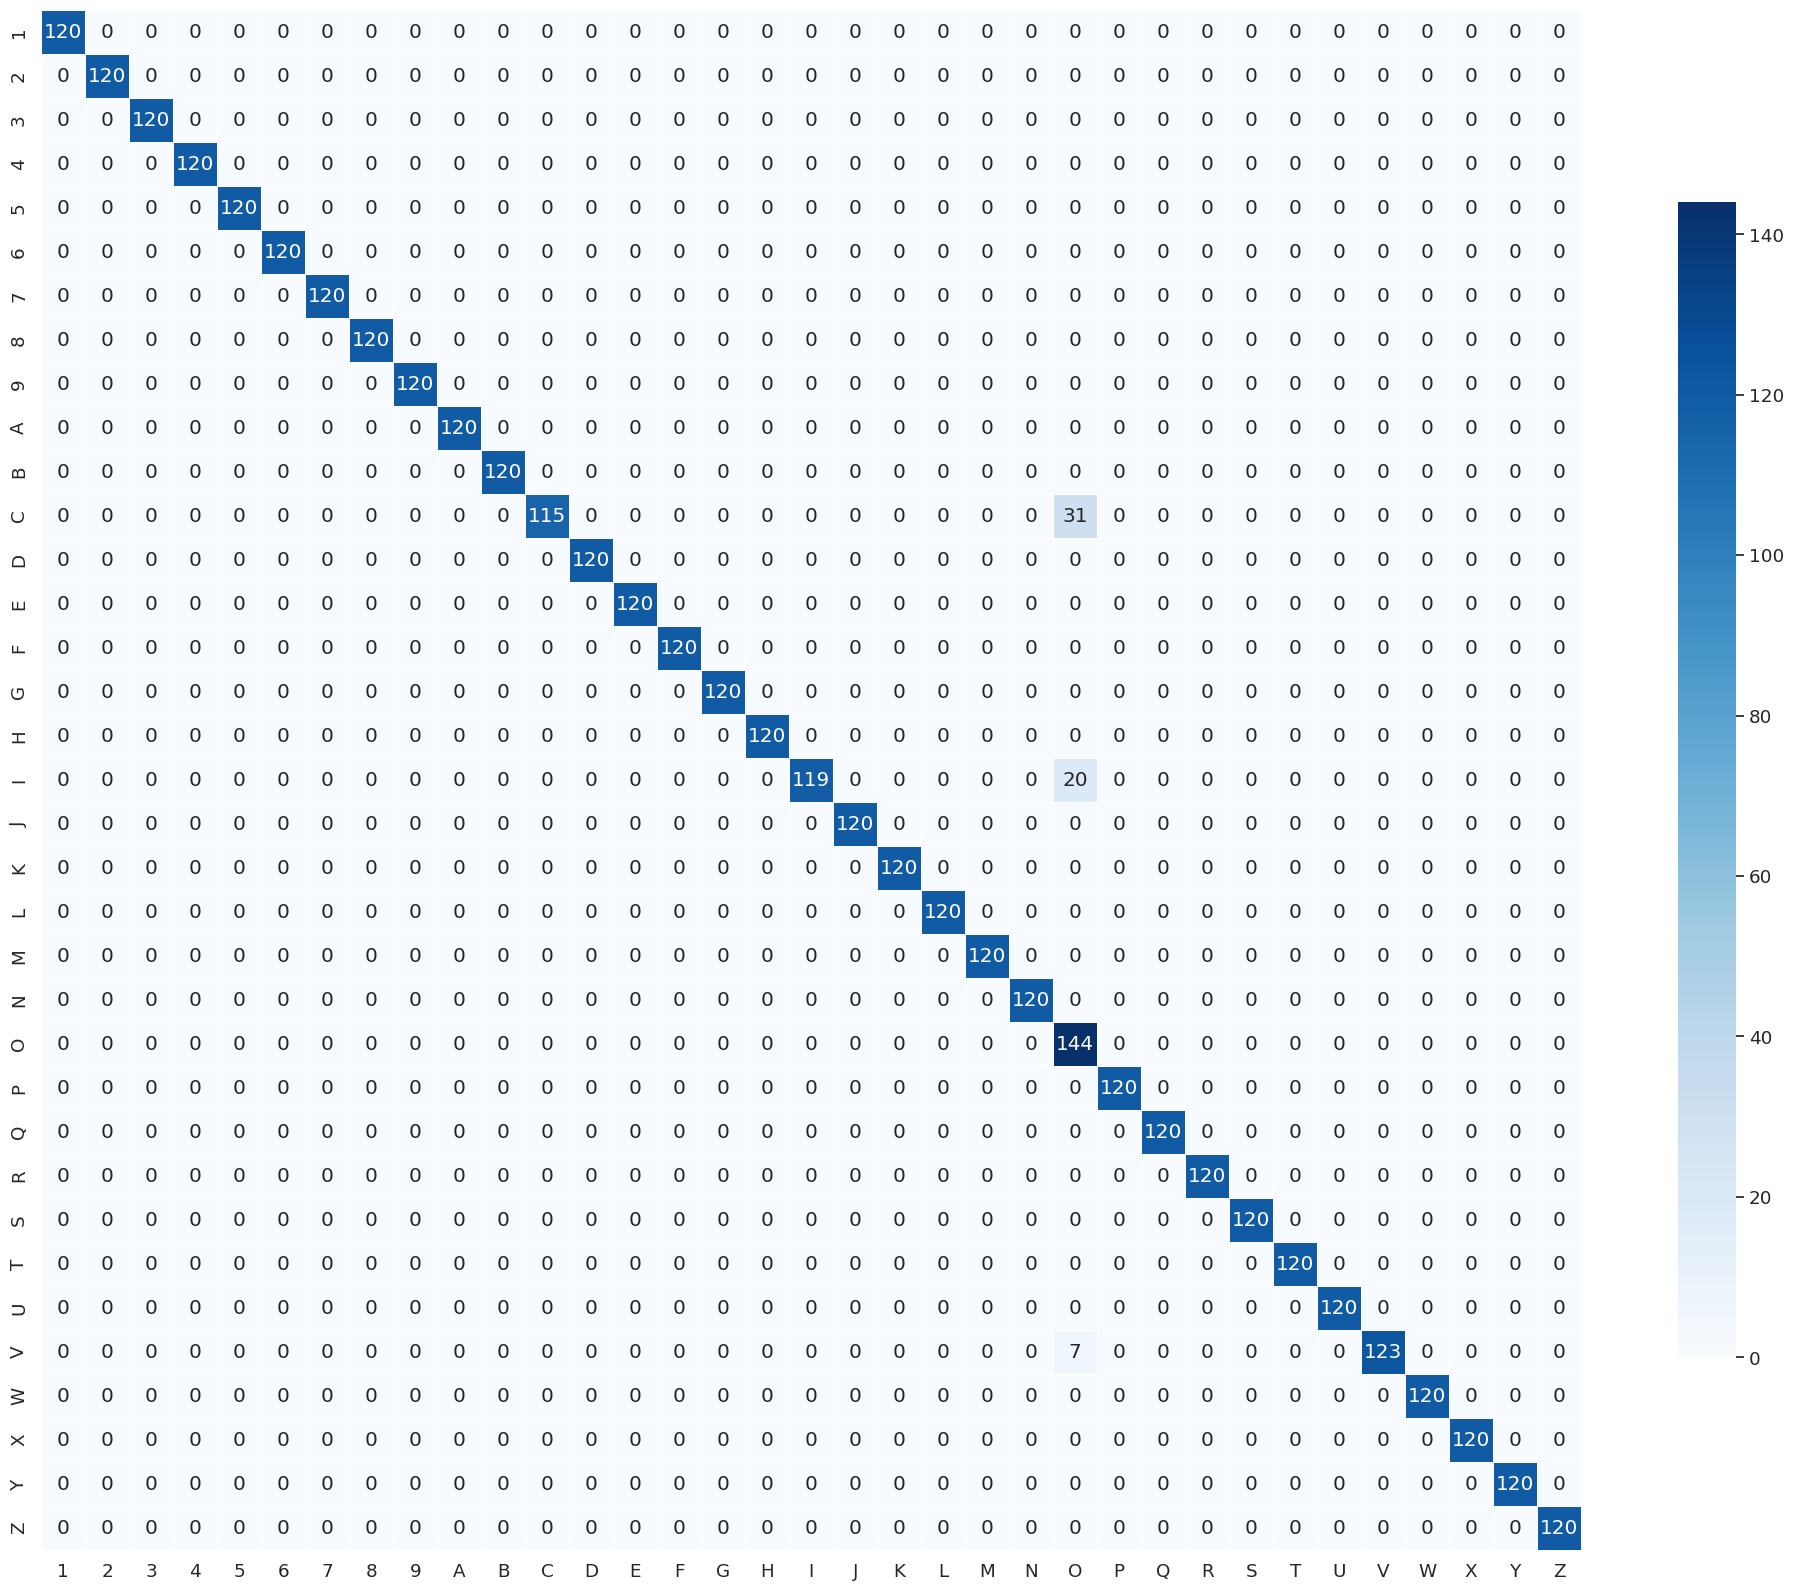

In [41]:
cm = confusion_matrix(y_true, y_pred)
sns.set(font_scale=1.2) 
plt.figure(figsize=(25, 20)) 
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            linewidths=.5, square=True,
            cbar_kws={"shrink": .75},
            xticklabels=target_names, 
            yticklabels=target_names)
plt.show()